## Project Title
Best model to predict most demanding time for Sweet Lift taxis

## Introduction
The purpose of this project is to assist Sweet Lift company to create a machine learning model so that it can predict which time of the day gets more busier so that it can higher more drivers at that time. 
They can focus on correct marketing channel so that more efficient hiring can be done with less marketing cost.


In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error 

In [3]:
df = pd.read_csv('taxi.csv')
df

,datetime,num_orders
0,3/1/2018 0:00,9
1,3/1/2018 0:10,14
2,3/1/2018 0:20,28
3,3/1/2018 0:30,20
4,3/1/2018 0:40,32
...,...,...
26491,8/31/2018 23:10,32
26492,8/31/2018 23:20,24
26493,8/31/2018 23:30,27
26494,8/31/2018 23:40,39


In [5]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
df.shape

(26496, 1)

In [7]:
df.isna().sum()

num_orders    0
dtype: int64

C:\Users\Sohin\AppData\Local\Temp\ipykernel_144312\3929153409.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H').sum()


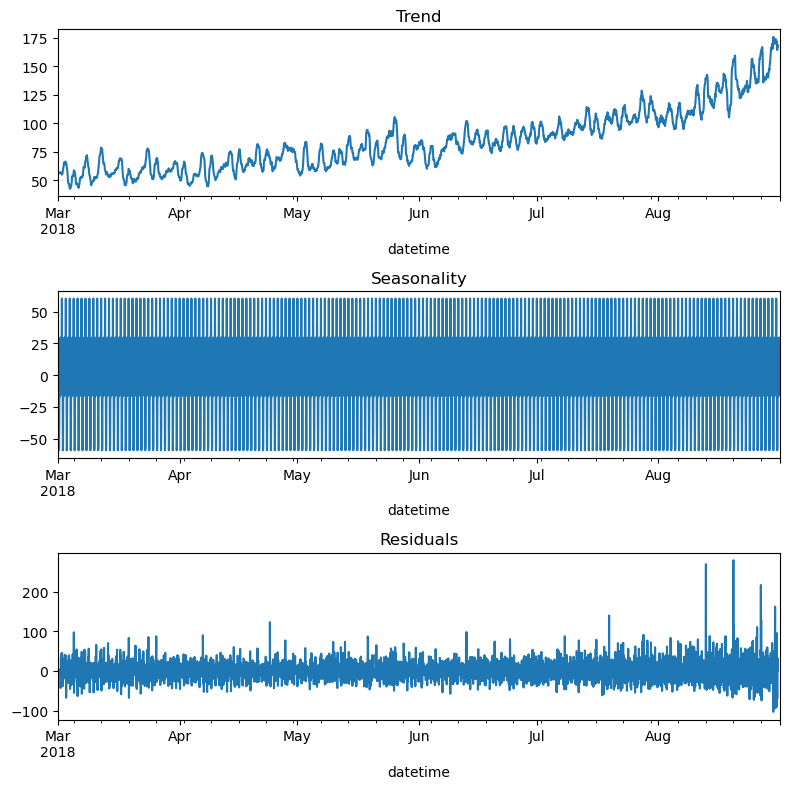

In [8]:

df_resampled = df.resample('1H').sum()
decomposed= seasonal_decompose(df_resampled['num_orders'], model='additive', period= 24)
 
plt.figure(figsize=(8,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

#### sampling the number of taxi orders on hourly basis and we can see the trend is rising as August is approaching.

In [9]:
def make_features(df_resampled, max_lag, rolling_mean_size):
        
        df_resampled['month'] = df_resampled.index.month
        df_resampled['day'] = df_resampled.index.day
        df_resampled['dayofweek'] = df_resampled.index.dayofweek
        df_resampled['hour'] = df_resampled.index.hour
        
        for lag in range (1, max_lag + 1): df_resampled['lag_{}'. format(lag)] = df_resampled['num_orders'].shift(lag)

        df_resampled['rolling_mean'] = (df_resampled['num_orders'].shift().rolling(rolling_mean_size).mean())

make_features(df_resampled,3,3)        


#### creating features like month, day, dayofweek and hour with numeric values to have proper model training.

In [10]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int32  
 2   day           4416 non-null   int32  
 3   dayofweek     4416 non-null   int32  
 4   hour          4416 non-null   int32  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   rolling_mean  4413 non-null   float64
dtypes: float64(4), int32(4), int64(1)
memory usage: 276.0 KB


In [11]:
df_resampled.describe()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4413.000000
mean,84.422781,5.505435,15.836957,3.005435,11.50000,84.395470,84.364069,84.347156,84.362867
std,45.023853,1.713306,8.855229,1.990684,6.92297,44.992356,44.949043,44.940088,37.984539
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.333333
25%,54.000000,4.000000,8.000000,1.000000,5.75000,54.000000,54.000000,54.000000,59.333333
50%,78.000000,5.500000,16.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.666667
75%,107.000000,7.000000,23.250000,5.000000,17.25000,107.000000,107.000000,107.000000,104.333333
max,462.000000,8.000000,31.000000,6.000000,23.00000,462.000000,462.000000,462.000000,319.666667


In [12]:
df_resampled= df_resampled.dropna()

In [13]:
train, test = train_test_split(df_resampled, shuffle = False, test_size= 0.1)


### Splitting the dataset in training and testing data set. 

In [14]:
train.isna().sum()


num_orders      0
month           0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
rolling_mean    0
dtype: int64

#### Found some missing data in train dataset. Lag columns has missing data because they do not have no previous information to work with.

In [15]:
train.dropna()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,93.333333
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,74.000000
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,60.000000
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,38.333333
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,20.333333
...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,8,13,0,9,91.0,39.0,66.0,65.333333
2018-08-13 10:00:00,156,8,13,0,10,137.0,91.0,39.0,89.000000
2018-08-13 11:00:00,144,8,13,0,11,156.0,137.0,91.0,128.000000


In [16]:
test.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
rolling_mean    0
dtype: int64

In [17]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


In [18]:
print(features_train.shape)
print(target_train.shape)

print(features_test.shape)
print(target_test.shape)


(3971, 8)
(3971,)
(442, 8)
(442,)


In [19]:
# Define the columns
numeric =['lag_1','lag_2','lag_3','rolling_mean']            

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric)])

features_train_transformed = preprocessor.fit_transform(features_train)
features_test_transformed = preprocessor.transform(features_test)

### Model training

In [20]:
model_dt = DecisionTreeRegressor(max_depth = 12, random_state =1234)
model_dt.fit(features_train_transformed, target_train)
pred_train= model_dt.predict(features_train_transformed)
rmse = mean_squared_error(pred_train, target_train)**0.5

print(f' RMSE of DecisionTree Model for training set:', rmse)


 RMSE of DecisionTree Model for training set: 21.34185724908328


#### The DecisionTree model has RMSE of 21.34 on training dataset.

In [21]:
model_rf = RandomForestRegressor(max_depth=6, n_estimators= 100, random_state=1234)
model_rf.fit(features_train, target_train)
pred_train= model_rf.predict(features_train)
rmse = mean_squared_error(pred_train, target_train)**0.5

print(f'RMSE for the training set of RandomForest Model:', rmse)

RMSE for the training set of RandomForest Model: 22.55867513543693


#### The RandomForest model has RSME of 22.55 on training dataset higher than DecisionTree model.

In [22]:
model = LinearRegression()
model.fit(features_train,target_train)
pred_train = model.predict(features_train)
rmse = mean_squared_error(pred_train, target_train)**0.5

print(f'RMSE for the training set of LinearRegression Model:', rmse)

RMSE for the training set of LinearRegression Model: 30.562437475482493


#### The LinearRegression model has highest RSME of 30.56 on training dataset.

In [23]:
model_lgb = LGBMRegressor(learning_rate =0.1, num_leaves =50)
model_lgb.fit(features_train, target_train)
pred_train = model_lgb.predict(features_train)
rmse = mean_squared_error(pred_train, target_train)**0.5

print(f'RMSE for the training set of LightGBMRegressor Model:', rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3971, number of used features: 8
[LightGBM] [Info] Start training from score 78.279275


c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

RMSE for the training set of LightGBMRegressor Model: 13.16657098224225


#### The LightGBMRegressor model has RMSE  of 13.16 on training dataset.

In [24]:
model_xgb = XGBRegressor(eta= 0.1, seed= 123)
model_xgb.fit(features_train, target_train)
pred_train = model_xgb.predict(features_train)
rmse = mean_squared_error(pred_train, target_train)**0.5

print(f'RMSE for the training set of XGBMRegressor Model:', rmse)

RMSE for the training set of XGBMRegressor Model: 13.216328631486311


#### The XGBRegressor model has RSME of 13.24 on training dataset similar to LightGBM model.

In [25]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
model_lgb = LGBMRegressor()
# Define the hyperparameters and their possible values
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [10],
    'n_estimators':[100],
    'num_leaves':[10, 20, 50],  

}

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Create a GridSearchCV object with TimeSeriesSplit
grid_search = GridSearchCV(estimator=model_lgb, param_grid=param_grid,
                           cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit to the data
grid_search.fit(features_train, target_train)

# Print the best parameters and RMSE
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print(f'Best Parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3971, number of used features: 8
[LightGBM] [Info] Start training from score 78.279275
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 10}
Best RMSE: 25.493622027431012


#### We can see that the best RMSE derived from TimeSeriesSplit is more than the earlier model training.The reason can be TimeSeriesSplit prioritizes generalization: It ensures that training happens on earlier data while validation occurs on later data, respecting the temporal order. This setup often sacrifices training accuracy (higher RMSE) in favor of producing a model that better predicts future data. In contrast, traditional cross-validation might allow leakage of future information, artificially lowering RMSE.

In [26]:
best_model = LGBMRegressor(max_depth= 10, learning_rate= 0.1, n_estimators= 100, num_leaves= 10)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
rmse = mean_squared_error(pred_test, target_test)**0.5

print(f'RMSE for the testing set of LGBMRegressor Model:', rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3971, number of used features: 8
[LightGBM] [Info] Start training from score 78.279275
RMSE for the testing set of LGBMRegressor Model: 44.620277730206915


#### The best model during training dataset was acquired by LGBMRegressor model. The best model was tested on testing dataset  and produced RMSE  of 44.62. The testing dataset has higher RMSE than training data set it means that the model is overfitted which means that the model was trained very specific to training dataset.

#### 

## Conclusion:

With help of this project Sweet Lift company will be successful in creating a machine learning model predict popular time of the day when there is high demand of taxi rides. The LGBMRegressor model is best model with the lowest RMSE of 44.62 on testing dataset. It performs well with non-linear relationships and high-dimensional datasets. LightGBM provides a clear ranking of feature importance, which aids interpretability.The other model were used for model training for comparision purposes were DecisionTreeRegressor, RandomForestRegressor and XGBoostRegressor. The DecisionTreeRegressor model has a RMSE of 21.34.The RandomForestRegressor model has RMSE of 22.55  .The LightGBMRegressor model has RMSE similar to XGBRegressor. Linear Regression has the worst RMSE.

This project was created by resampling the data by hourly basis and creating features like hour, day, day of week and month. Missing values were dropped from train data. dataset was split into training and test dataset and eventually trained the model.
